In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.3.0+cu121, Device: cpu


하이퍼 파라미터

In [ ]:
FEATURE_NUMS = 4        # 입력층으로 들어가는 데이터 개수 feature
SEQ_LENGTH = 5          # 정답을 만들기 위해 필요한 시점 개수 time step
HIDDEN_SIZE = 4         # RNN 계열 계층을 구성하는 hidden state 개수
NUM_LAYERS = 1          # RNN 계열 계층이 몇겹으로 쌓였는지 나타냄
LEARNING_RATE = 1e-3    # 학습율
BATCH_SIZE = 20         # 학습을 위한 배치사이즈 개수

In [ ]:
pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

df = fdr.DataReader('005930', '2020-01-01', '2024-06-30')

df = df[ ['Open', 'High', 'Low', 'Volume', 'Close'] ]

df.head(10)

,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,55500,56000,55000,12993228,55200
2020-01-03,56000,56600,54900,15422255,55500
2020-01-06,54900,55600,54600,10278951,55500
2020-01-07,55700,56400,55600,10009778,55800
2020-01-08,56200,57400,55900,23501171,56800
2020-01-09,58400,58600,57400,24102579,58600
2020-01-10,58800,59700,58300,16000170,59500
2020-01-13,59600,60000,59100,11359139,60000
2020-01-14,60400,61000,59900,16906295,60000


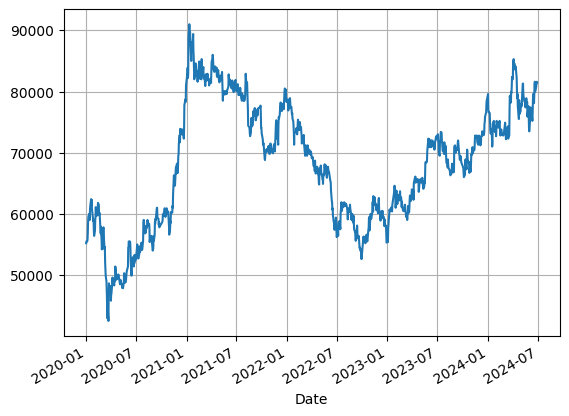

In [ ]:
df['Close'].plot().grid()

In [ ]:
# train : test - 70 : 30 분리

SPLIT = int(0.7*len(df))  # train : test = 7 : 3

train_df = df[ :SPLIT ]
test_df = df[ SPLIT: ]

In [ ]:
scaler_x = MinMaxScaler()  # feature scaling

train_df.iloc[ : , :-1 ] = scaler_x.fit_transform(train_df.iloc[ : , :-1 ])
test_df.iloc[ : , :-1 ] = scaler_x.fit_transform(test_df.iloc[ : , :-1 ])

scaler_y = MinMaxScaler()  # label scaling

train_df.iloc[ : , -1 ] = scaler_y.fit_transform(train_df.iloc[ : , [-1] ])
test_df.iloc[ : , -1 ] = scaler_y.fit_transform(test_df.iloc[ : , [-1] ])

In [ ]:
def MakeSeqNumpyData(data, seq_length):

    x_seq_list = []
    y_seq_list = []

    for i in range(len(data) - seq_length):
        x_seq_list.append(data[ i:i+seq_length, :-1 ])
        y_seq_list.append(data[ i+seq_length, [-1] ])

    x_seq_numpy = np.array(x_seq_list)
    y_seq_numpy = np.array(y_seq_list)

    return x_seq_numpy, y_seq_numpy

In [ ]:
x_train_data, y_train_data = MakeSeqNumpyData(np.array(train_df), SEQ_LENGTH)

x_test_data, y_test_data = MakeSeqNumpyData(np.array(test_df), SEQ_LENGTH)

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(770, 5, 4) (770, 1)
(328, 5, 4) (328, 1)


In [ ]:
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)

x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class MyLSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, data):
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)

        outputs, _ = self.lstm(data, (h0, c0))
        last_hs = outputs[:, -1, :]
        prediction = self.fc(last_hs)

        return prediction

In [ ]:
model = MyLSTMModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = 0

    total_train_batch = len(dataloader)

    for inputs, labels in dataloader:

        x_train = inputs.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

    train_avg_loss = train_loss_sum / total_train_batch

    return train_avg_loss

In [ ]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = 0

        total_val_batch = len(dataloader)

        for inputs, labels in dataloader:

            x_val = inputs.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

        val_avg_loss = val_loss_sum / total_val_batch

    return val_avg_loss

In [ ]:
from datetime import datetime

train_loss_list = []

start_time = datetime.now()

EPOCHS = 200

for epoch in range(EPOCHS):

    avg_loss = model_train(train_loader, model, loss_function, optimizer)

    train_loss_list.append(avg_loss)

    if (epoch % 10 == 0):
        print('epoch: ', epoch, ', train loss = ', avg_loss)

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch:  0 , train loss =  0.8417484936041709
epoch:  10 , train loss =  0.0021788034056767058
epoch:  20 , train loss =  0.0013252360759696995
epoch:  30 , train loss =  0.0011832934262481732
epoch:  40 , train loss =  0.0011157358836872168
epoch:  50 , train loss =  0.0010807802762615327
epoch:  60 , train loss =  0.0010600173748874415
epoch:  70 , train loss =  0.0010476051964080678
epoch:  80 , train loss =  0.0010408624280572464
epoch:  90 , train loss =  0.0010372480561879154
epoch:  100 , train loss =  0.0010345878996677361
epoch:  110 , train loss =  0.0010312634493367602
epoch:  120 , train loss =  0.0010259002230715198
epoch:  130 , train loss =  0.0010175940488130809
epoch:  140 , train loss =  0.0010066462978452013
epoch:  150 , train loss =  0.0009941407688296377
epoch:  160 , train loss =  0.0009807963625718958
epoch:  170 , train loss =  0.000966880464544281
epoch:  180 , train loss =  0.0009525440079577935
epoch:  190 , train loss =  0.0009378698887303472
elapsed time =>

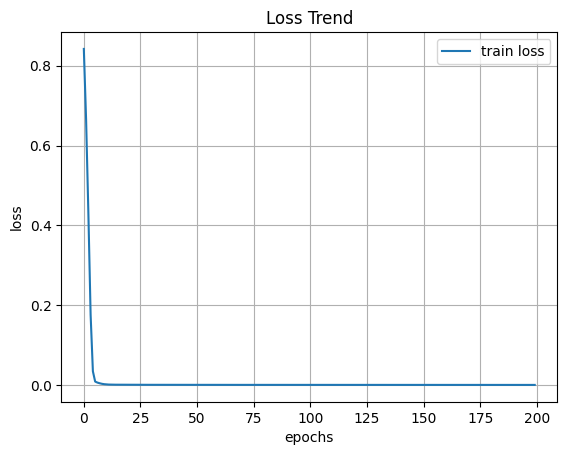

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train loss')
plt.legend()
plt.show()

In [ ]:
test_pred_tensor = model(x_test_tensor)

test_pred_numpy = test_pred_tensor.cpu().detach().numpy()

pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

y_test_numpy = y_test_tensor.cpu().detach().numpy()

y_test_inverse = scaler_y.inverse_transform(y_test_numpy)

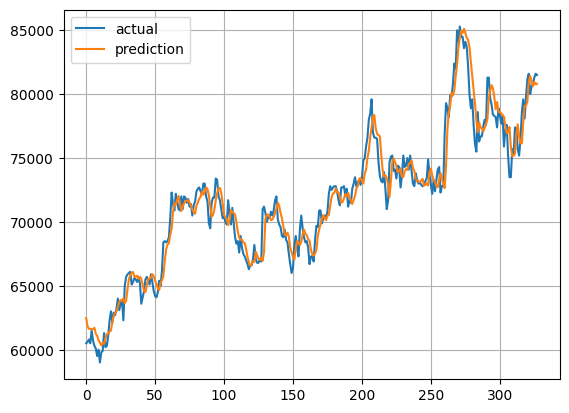

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_inverse, label='actual')
plt.plot(pred_inverse, label='prediction')
plt.grid()
plt.legend()

plt.show()

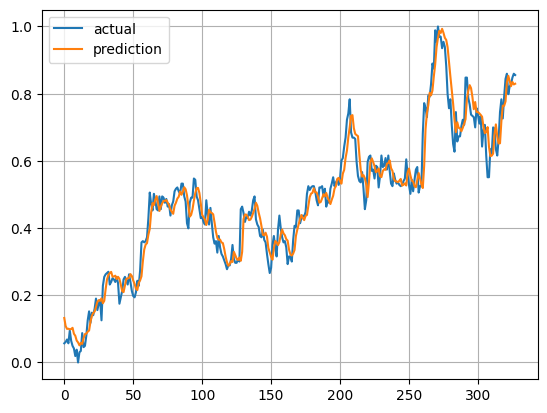

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_numpy, label='actual')
plt.plot(test_pred_numpy, label='prediction')
plt.grid()
plt.legend()

plt.show()